In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from collections import defaultdict
import os
import json
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from src.dataset_handling import TextClassificationDataset
from src.utils import get_activations_and_labels, get_hidden_activations
from src.sparse_autoencoders import SAE_topk

In [3]:
model_url = "EleutherAI/pythia-14m"
model_name = model_url.split('/')[-1]
hookpoint_name = 'gpt_neox.layers.$.mlp.act'
layer = 3

model = AutoModelForCausalLM.from_pretrained(model_url).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_url)

num_hookpoints = model.config.num_hidden_layers
hookpoint = hookpoint_name.replace('$', str(layer))
input_size = model.config.intermediate_size

In [6]:
expansion_factor = 4
k = int(np.sqrt(input_size * expansion_factor))

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': k
}

sae = SAE_topk(meta_data=meta_data)

sae.load_state_dict(torch.load(f'models/sparse_autoencoders/pythia-14m/topk{k}/{hookpoint}.pt', weights_only=True, map_location=torch.device('cpu')))

RuntimeError: Error(s) in loading state_dict for SAE_topk:
	Missing key(s) in state_dict: "pre_encode_b". 

In [86]:
def get_biling_acts(dataset, model, tokenizer, stop_after = 100):

    da_acts = []
    da_preacts = []
    da_tokens = []
    en_acts = []
    en_preacts = []
    en_tokens = []

    for i in range(stop_after):

        sent, label = dataset[i]

        tokenized = [
            tokenizer(input_, return_tensors='pt').to(device)
            for input_ in [sent]
        ]

        transformer_acts = get_hidden_activations(model, hookpoint, tokenized)

        sae_preacts = sae.get_preacts(transformer_acts)
        sae_acts = sae.get_activations(transformer_acts)

        for act_indices, preacts, token in zip(sae_acts.indices, sae_preacts, tokenized[0]['input_ids'][0]):

            zeros = torch.zeros(input_size * expansion_factor)

            zeros[act_indices] = 1

            if label == 0:
                da_acts.append(zeros)
                da_preacts.append(preacts)
                da_tokens.append(token.item())
            else:
                en_acts.append(zeros)
                en_preacts.append(preacts)
                en_tokens.append(token.item())

    return da_acts, da_preacts, da_tokens, en_acts, en_preacts, en_tokens

In [87]:
## TEXT PRINTING

def format_chars(text):
    formatted = (
        text.replace('Ġ', ' ').
            replace('Ã¥', 'å').
            replace('Ã¦', 'æ').
            replace('Ã¸', 'ø')
    )
    return formatted


# absolute genius stuff form chatgpt

def rgb_text(text, r, g, b, background=False):
    """Returns text formatted with 24-bit RGB color."""
    if background:
        if (r + g + b) / 3 > 128:
            return f"\033[38;2;0;0;0m\033[48;2;{r};{g};{b}m{text}\033[0m" 
        else:
            return f"\033[48;2;{r};{g};{b}m{text}\033[0m"
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"




def print_colored_preacts(tokens, preacts, neuron, tokenizer, stop_after=100):
    
    for idx, (token, preact) in enumerate(zip(tokens, preacts)):
        if idx == stop_after:
            break
        if idx % 20 == 0:
            print('')
        formatted = format_chars(tokenizer.convert_ids_to_tokens(token))
        value = preact[neuron].item() / 2

        if value > 0:
            print(rgb_text(formatted, r=int(abs(value) * 255), g=0, b=0, background=True), end='')
        else:
            print(rgb_text(formatted, r=0, g=0, b=int(abs(value) * 255), background=True), end='')


def print_colored_acts(tokens, acts, neuron, tokenizer, stop_after=100):

    for idx, (token, act) in enumerate(zip(tokens, acts)):
        if idx == stop_after:
            break
        if idx % 20 == 0:
            print('')

        formatted = format_chars(tokenizer.convert_ids_to_tokens(token))
        value = act[neuron].item()

        if value:
            print(rgb_text(formatted, r=255, g=0, b=0, background=True), end='')
        else:
            print(rgb_text(formatted, r=0, g=0, b=0, background=True), end='')



def plot_difference_by_neuron(da_preacts, en_preacts, neuron):

    da_preacts_tnsr = torch.stack(da_preacts).detach()
    en_preacts_tnsr = torch.stack(en_preacts).detach()

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    ax.set_title(f'Neuron {neuron}')
    ax.hist(da_preacts_tnsr[:, neuron], bins=30, alpha=0.5, color='blue', label='Danish')
    ax.hist(en_preacts_tnsr[:, neuron], bins=30, alpha=0.5, color='orange', label='English')

    fig.legend()

    fig.tight_layout()
    fig.show()

In [100]:
# for identifying neurons overrepresented in one language

data_path = 'data/split/tedtalks_test.tsv'
dataset = TextClassificationDataset.from_tsv(data_path)

da_acts, da_preacts, da_tokens, en_acts, en_preacts, en_tokens = get_biling_acts(dataset, model, tokenizer, stop_after=500)


# for checking those neurons

data_path = 'data/parallel/ELRC_2923.tmx'
dataset = TextClassificationDataset.from_tmx(data_path, 'da', 'en')

da_acts2, da_preacts2, da_tokens2, en_acts2, en_preacts2, en_tokens2 = get_biling_acts(dataset, model, tokenizer, stop_after=500)

In [98]:
da_acts_tnsr = torch.stack(da_acts)

In [99]:
sum(da_acts_tnsr.sum(dim=0) > 0)

tensor(771)

In [76]:
# getting overrepresented neurons

avg_da = sum(da_acts) / len(da_acts)
avg_en = sum(en_acts) / len(en_acts)

max_diff_neuron = torch.argmax(avg_da - avg_en).item()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_6900\4195699595.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


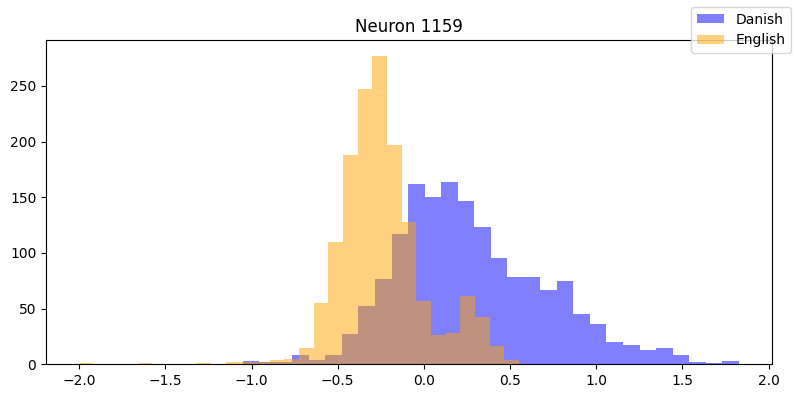

In [77]:
plot_difference_by_neuron(da_preacts, en_preacts, max_diff_neuron)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_6900\4195699595.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


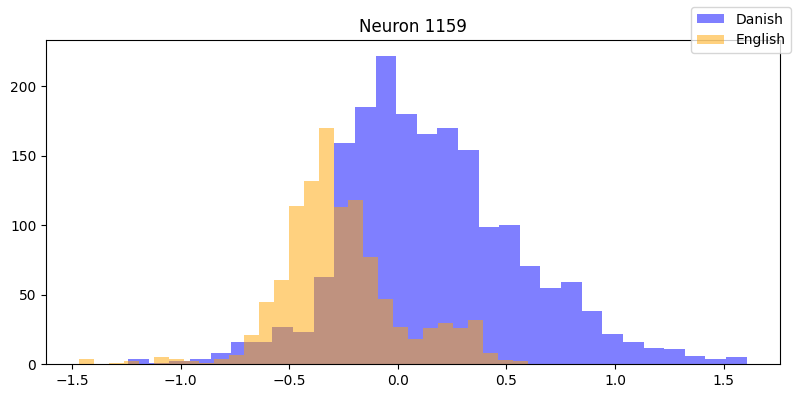

In [78]:
plot_difference_by_neuron(da_preacts2, en_preacts2, max_diff_neuron)

In [79]:
begin_at = 100


print_colored_acts(
    da_tokens2[begin_at:], 
    da_acts2[begin_at:], 
    max_diff_neuron, 
    tokenizer, 
    stop_after=400
)
print('')
print_colored_acts(
    en_tokens2[begin_at:], 
    en_acts2[begin_at:], 
    max_diff_neuron, 
    tokenizer, 
    stop_after=400
)


 mindre end to uger efter, at Kommissionen fremsatte sine forslag.Mid
lerne vil blive rettet mod sundhedssystemer, SMV'er,
 arbejdsmarkeder og andre sårbare dele af EU-medlemslandenes ø
konomier.Formålet med disse foranstaltninger er at kanalisere
 37 mia. EUR fra eksisterende EU-midler til de borgere,
 regioner og lande, der er hårdest ramt af Coronavirus-pandemien
 så hurtigt som muligt.Som en del af EU's fælles svar
 mod COVID-19-udbruddet vedtog medlemmerne næsten en
stemmigt tre hasteforslag på en ekstraordinær plenarforsamling tors
dag.Dette vil forhindre luftfartsselskaberne i at fly
ve med tomme fly under pandemien.Støtteberettigede tiltag under
 fonden, vil blive udvidet til også at omfatte støtte i for
bindelse med større folkesundhedskriser, herunder lægeh
jælp, samt foranstaltninger til forebyggelse, overvå
gning eller bekæmpelse af spredning af sygdomme.Udvidel
se af EU's Solidaritetsfond til at omfatte krisesituationer
 på folkesundhedsområdet.De vedtagne foranstaltninge

In [80]:
print_colored_preacts(
    da_tokens2[begin_at:], 
    da_preacts2[begin_at:], 
    max_diff_neuron, 
    tokenizer, 
    stop_after=400
)
print('')
print_colored_preacts(
    en_tokens2[begin_at:], 
    en_preacts2[begin_at:], 
    max_diff_neuron, 
    tokenizer, 
    stop_after=400
)


 mindre end to uger efter, at Kommissionen fremsatte sine forslag.Mid
lerne vil blive rettet mod sundhedssystemer, SMV'er,
 arbejdsmarkeder og andre sårbare dele af EU-medlemslandenes ø
konomier.Formålet med disse foranstaltninger er at kanalisere
 37 mia. EUR fra eksisterende EU-midler til de borgere,
 regioner og lande, der er hårdest ramt af Coronavirus-pandemien
 så hurtigt som muligt.Som en del af EU's fælles svar
 mod COVID-19-udbruddet vedtog medlemmerne næsten en
stemmigt tre hasteforslag på en ekstraordinær plenarforsamling tors
dag.Dette vil forhindre luftfartsselskaberne i at fly
ve med tomme fly under pandemien.Støtteberettigede tiltag under
 fonden, vil blive udvidet til også at omfatte støtte i for
bindelse med større folkesundhedskriser, herunder lægeh
jælp, samt foranstaltninger til forebyggelse, overvå
gning eller bekæmpelse af spredning af sygdomme.Udvidel
se af EU's Solidaritetsfond til at omfatte krisesituationer
 på folkesundhedsområdet.De vedtagne foranstaltninge

In [ ]:
hidden_acts_outfolder = 'results/sparse_autoencoder_activations'

if not os.path.isdir(f'{hidden_acts_outfolder}'):
    os.mkdir(f'{hidden_acts_outfolder}')

if not os.path.isdir(f'{hidden_acts_outfolder}/{model_name}'):
    os.mkdir(f'{hidden_acts_outfolder}/{model_name}')

df = pd.DataFrame({'avg_da': avg_da.numpy(), 'avg_en': avg_en.numpy()})
df.to_csv(f'{hidden_acts_outfolder}/{model_name}/{hookpoint}.csv', index=False)